In [1]:
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
import numpy.matlib as npmb
import h5py
%matplotlib notebook

<IPython.core.display.Javascript object>


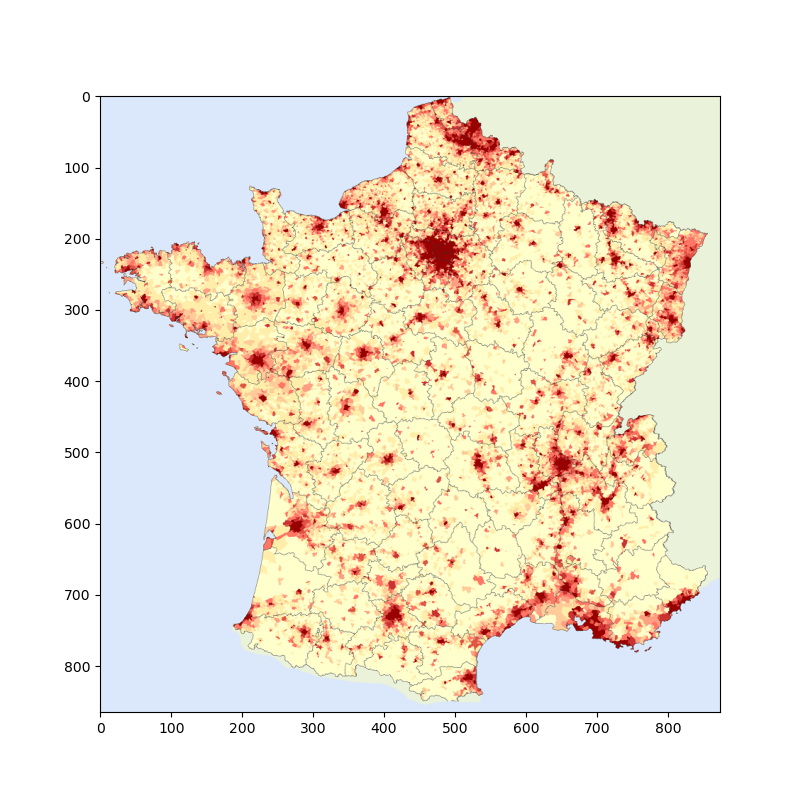

Intérieur+Frontière: 


<IPython.core.display.Javascript object>


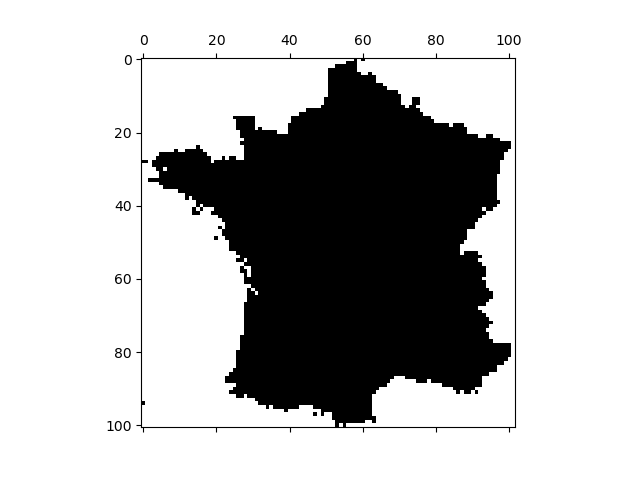

Frontière : 


<IPython.core.display.Javascript object>


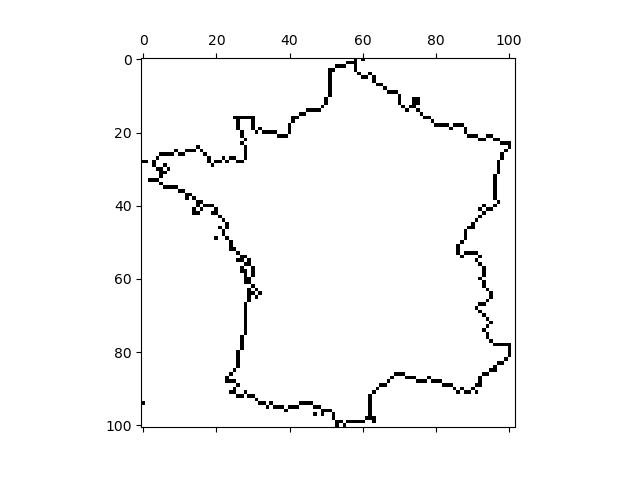

Densité:


<IPython.core.display.Javascript object>


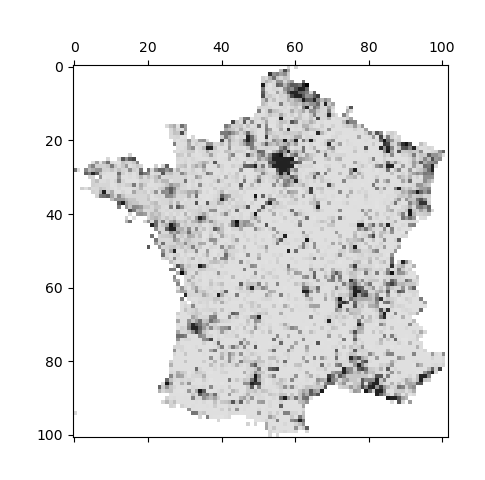

In [55]:
## Generate 2D grid with metropolitan France border

plt.figure(figsize=(8,8))
A = PIL.Image.open('France_population_density_3.png') # Ouverture
T = np.array(A)
plt.imshow(T) 
plt.axis('equal')
plt.show()

ax,ay=A.size #size donne (width, height)

J1=101               # along vertical axis
J2=round(ax/ay*J1)   # keep x:y ratio
NG = J2*J1           # nbr of points in the grid

#T = T/255
Xint=np.arange(J2)
Yint=np.arange(J1)
x=np.arange(ax)
y=np.arange(ay)
f1=interpolate.interp2d(x,y,T[:,:,0],'cubic')
f2=interpolate.interp2d(x,y,T[:,:,1],'cubic')
f3=interpolate.interp2d(x,y,T[:,:,2],'cubic')
countryr = f1((Xint-0.5)*ax/J2,(Yint-0.5)*ay/J1)
countryg = f2((Xint-0.5)*ax/J2,(Yint-0.5)*ay/J1)
countryb = f3((Xint-0.5)*ax/J2,(Yint-0.5)*ay/J1)
country = np.zeros((J1,J2,3))
country[:,:,0] = countryr;
country[:,:,1] = countryg;
country[:,:,2] = countryb;


densite_temp=np.ones((J1+2,J2+2))
densite_temp[:,0]=0
densite_temp[:,J2+1]=0
densite_temp[0,:]=0
densite_temp[J1+1,:]=0
for i in range(J1):
    for j in range(J2):
        if (abs(country[i,j,0]-219)<2 and abs(country[i,j,1]-232)<2 and abs(country[i,j,2]-252)<2) or (abs(country[i,j,0]-234)<2 and abs(country[i,j,1]-242)<2 and abs(country[i,j,2]-217)<2): 
            #En RGB bleu=[219,232,252] et vert=[234,242,217]
            densite_temp[i+1,j+1]=0
 
            
densite=np.ones((J1,J2))
densite=densite_temp[1:J1+1,1:J2+1]
print('Intérieur+Frontière: ')
plt.figure()
plt.spy(densite,origin='upper')
plt.show()  

index_x=[]
index_y=[]
for i in range(J1):
    for j in range(J2):
        if densite[i,j]!=0:
            index_x=index_x+[i]
            index_y=index_y+[j]

interior = np.ravel_multi_index(np.array([index_x,index_y]), (J1,J2),order='F')
interior=np.unique(interior)

border_x=[]
border_y=[]
for i in range(1,J1+1):
    for j in range(1,J2+1):
        if densite[i-1,j-1]!=0 and (densite_temp[i,j-1]==0 or densite_temp[i,j+1]==0 or densite_temp[i-1,j]==0 or densite_temp[i+1,j]==0):
            border_x=border_x+[i-1]
            border_y=border_y+[j-1]

border = np.ravel_multi_index(np.array([border_x,border_y]), (J1,J2),order='F')
border=np.unique(border)
print('Frontière : ')
G=np.zeros(NG)
G[border]=1
G=np.reshape(G,(J1,J2),order='F')
plt.figure()
plt.spy(G)
plt.show()

interior=np.setdiff1d(interior,border)

B=A.convert(mode='L')
T2=np.array(B)
f4=interpolate.interp2d(x,y,T2,'cubic')
countrybw = f4((Xint-0.5)*ax/J2,(Yint-0.5)*ay/J1)
countrybw=60+np.abs(countrybw-255)
countrybw[densite==0]=0

print('Densité:')
plt.matshow(countrybw,cmap="Greys")
plt.show()

f1 = h5py.File("grid_2.hdf5", "w")
dset1 = f1.create_dataset("interior", (1,np.size(interior)), dtype='i', data=interior)
dset1 = f1.create_dataset("border", (1,np.size(border)), dtype='i', data=border)
dset1 = f1.create_dataset("J1",(1,1), dtype='i', data=J1)
dset1 = f1.create_dataset("J2", (1,1), dtype='i', data=J2)
dset1 = f1.create_dataset("densite", (J1,J2), dtype='i', data=countrybw)
f1.close()
